In [4]:
#imported usefull libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# **EDA**

In [5]:
import pandas as pd 
train_csv = pd.read_csv('/kaggle/input/landmark-recognition-2020/train.csv')
train_csv.head()
#read the main file train and displayed top 5 rows

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [6]:
#Number of unique landmarks
train_csv['landmark_id'].nunique()

81313

In [7]:
train_csv['landmark_id'].value_counts()
#count of each landmark

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
          ... 
84677        2
36989        2
133688       2
17316        2
111405       2
Name: landmark_id, Length: 81313, dtype: int64

In [8]:
#top 10 landmarks which were most visited
top10 = pd.DataFrame(train_csv['landmark_id'].value_counts().head(10))
top10.reset_index(inplace=True)
top10.columns = ['landmark_id', 'value_count']
top10.set_index('landmark_id',inplace=True)
top10

,value_count
landmark_id,
138982,6272
126637,2231
20409,1758
83144,1741
113209,1135
177870,1088
194914,1073
149980,971
139894,966


In [9]:
#visualization of top-10 landmarks
!pip install pandas-bokeh
import pandas_bokeh
pandas_bokeh.output_notebook()
top10.plot_bokeh.bar(
    ylabel="Count", 
    title="Top-10 landmark id", 
    alpha=0.6)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Loading BokehJS ...

Figure(id='1039', ...)

In [10]:
#below 20 landmarks -> least visited | or have least images
least10 = pd.DataFrame(train_csv['landmark_id'].value_counts().tail(20))
least10.reset_index(inplace=True)
least10.columns = ['landmark_id', 'value_count']
least10.set_index('landmark_id',inplace=True)
least10

,value_count
landmark_id,
53433,2
133536,2
53442,2
133574,2
84829,2
17230,2
84803,2
189164,2
84800,2


In [11]:
#least 20 landmarks
import pandas_bokeh
pandas_bokeh.output_notebook()
plt.figure(figsize=(50,50))
least10.plot_bokeh.bar(
    ylabel="Count", 
    title="Top-20 landmark id", 
    alpha=0.6)

Loading BokehJS ...

Figure(id='1184', ...)

<Figure size 3600x3600 with 0 Axes>

In [12]:
train_csv = pd.read_csv('/kaggle/input/landmark-recognition-2020/train.csv')
train_csv.head(10)

# put .jpg into the file name
def add_txt(fn):
    return fn+'.jpg'

train_csv['id'] = train_csv['id'].apply(add_txt)



# choose those labels with more than 200 images, and choose the first 200 images of each label
# move every training files to the same folder
%cd /kaggle/working
if not os.path.exists('training'):
    os.mkdir('training')
if not os.path.exists('validation'):
    os.mkdir('validation')
if not os.path.exists('testing'):
    os.mkdir('testing')    

import shutil
import random

label_list = train_csv['landmark_id'].unique()
cnt = 0
final_label_list = []

for label in list(label_list): # label order by random
    file_list = list(train_csv['id'][train_csv['landmark_id']==label])
    if len(file_list) >= 200:
        final_label_list.append(label)
        if not os.path.exists('/kaggle/working/training/'+str(label)):
            os.mkdir('/kaggle/working/training/'+str(label))
        if not os.path.exists('/kaggle/working/validation/'+str(label)):
            os.mkdir('/kaggle/working/validation/'+str(label))
        if not os.path.exists('/kaggle/working/testing/'+str(label)):
            os.mkdir('/kaggle/working/testing/'+str(label))
        for file in file_list[:120]:  # 120 files for training
            src = '/kaggle/input/landmark-recognition-2020/train/'+file[0]+'/'+file[1]+'/'+file[2]+'/'+file
            dst = '/kaggle/working/training/'+str(label)+'/'+file
            if not os.path.exists(dst):
                shutil.copyfile(src, dst)
        for file in file_list[120:160]: # 40 files for validation
            src = '/kaggle/input/landmark-recognition-2020/train/'+file[0]+'/'+file[1]+'/'+file[2]+'/'+file
            dst = '/kaggle/working/validation/'+str(label)+'/'+file
            if not os.path.exists(dst):
                shutil.copyfile(src, dst)
        for file in file_list[160:200]: # 40 files for testing
            src = '/kaggle/input/landmark-recognition-2020/train/'+file[0]+'/'+file[1]+'/'+file[2]+'/'+file
            dst = '/kaggle/working/testing/'+str(label)+'/'+file
            if not os.path.exists(dst):
                shutil.copyfile(src, dst)
        cnt += 1
    if cnt == 100: # only need 100 labels
        break

/kaggle/working


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Our original imagess are in RGB coefficients ranging from 0 to 255,
#but such values would be too high for our model to process, 
#therefore we scale with a 1/255 to target values between 0 and 1

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/kaggle/working/training'
validation_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/testing'

# The flow_from_directory() method allows to read the images directly from the directory train and valid files and augment them 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200,200),
    batch_size = 32,
    class_mode='categorical',
    seed=42)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(200,200),
    batch_size = 32,
    class_mode='categorical',
    seed=123)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200,200),
    batch_size = 1,
    class_mode='categorical',
    seed=123)

Found 12000 images belonging to 100 classes.
Found 4000 images belonging to 100 classes.
Found 4000 images belonging to 100 classes.


# **EfficientNet**

In [14]:
#This neural network uses  compound scaling that addsmore layers, more nodes per layer, or better resolution for filters 
# whichcan improve a model. 
# Compound scaling uniformly scales all three of these dimensions with a compound coefficient

a = tf.keras.applications.EfficientNetB2(include_top=False,
                    weights="imagenet",
                    input_shape=(200,200, 3))
a.trainable = True
a.summary()
#getting an error while using input_shape same as target size

2022-08-11 04:22:47.582349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 04:22:47.743565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 04:22:47.747840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 04:22:47.753407: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

31801344/31790344 [==============================] - 1s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 200, 200, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 201, 201, 3)  0           normalization[0][0]              
____________________

In [15]:
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, Flatten, Conv2D, Input
from tensorflow.keras import optimizers
import tensorflow as tf

In [16]:
model = Sequential() # sequence of layer of neural network
model.add(a)
model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='relu')) #adding a layer of neurons #rectified linear unit it oly pass value 0 or greater than 0 to the next layer in the network

In [17]:
model.compile(optimizer='Adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               140900    
Total params: 7,909,469
Trainable params: 7,841,894
Non-trainable params: 67,575
_________________________________________________________________


In [19]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator, verbose =1
)
#it tells us about accuracy of the model for epochs 10. this tell how much neural network is accurate

2022-08-11 04:22:58.199397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-11 04:23:14.772769: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


375/375 [==============================] - 192s 449ms/step - loss: 5.8175 - accuracy: 0.0231 - val_loss: 4.8990 - val_accuracy: 0.0100
Epoch 2/10
375/375 [==============================] - 166s 443ms/step - loss: 4.8985 - accuracy: 0.0252 - val_loss: 4.7226 - val_accuracy: 0.0132
Epoch 3/10
375/375 [==============================] - 167s 446ms/step - loss: 4.8216 - accuracy: 0.0366 - val_loss: 13.6838 - val_accuracy: 0.0100
Epoch 4/10
375/375 [==============================] - 166s 442ms/step - loss: 4.8392 - accuracy: 0.0179 - val_loss: 13.0982 - val_accuracy: 0.0100
Epoch 5/10
375/375 [==============================] - 166s 443ms/step - loss: 4.7949 - accuracy: 0.0127 - val_loss: 5.6024 - val_accuracy: 0.0100
Epoch 6/10
375/375 [==============================] - 166s 442ms/step - loss: 4.6153 - accuracy: 0.0217 - val_loss: 4.6623 - val_accuracy: 0.0100
Epoch 7/10
375/375 [==============================] - 167s 446ms/step - loss: 4.6668 - accuracy: 0.0247 - val_loss: 5.2884 - val_accu

In [20]:
scores = model.evaluate(test_generator)
print(scores)
#it test the accuracy on the test data it make prediction on the test data accuracy

4000/4000 [==============================] - 100s 25ms/step - loss: 5.8580 - accuracy: 0.0093
[5.857995510101318, 0.00925000011920929]


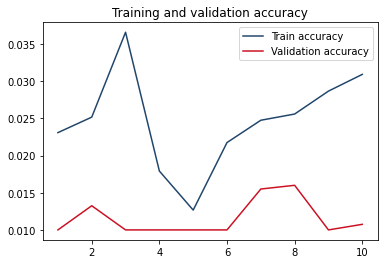

In [21]:
epochs = range(1, len(history.history['accuracy'])+1)

plt.plot(epochs, history.history['accuracy'], '#21466C', label='Train accuracy')
plt.plot(epochs, history.history['val_accuracy'], '#cc1123', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# **RESNET**

In [22]:
#ResNet-50  reduced the vanishing gradient problem while also not adding additional parameters to the model.

b = tf.keras.applications.ResNet50V2(include_top=False,
                    weights="imagenet",
                    input_shape=(200,200, 3))
b.trainable = True
b.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 102, 102, 64) 0           conv1_conv[0][0]                 
________________________

In [23]:
model2 = Sequential()
model2.add(b)
model2.add(GlobalAveragePooling2D())
#model2.add(Flatten())
model2.add(Dense(100,activation='sigmoid'))
#model2.add(Dense(10))

In [24]:
model2.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               204900    
Total params: 23,769,700
Trainable params: 23,724,260
Non-trainable params: 45,440
_________________________________________________________________


In [25]:
history2 = model2.fit(train_generator,epochs=10,validation_data=validation_generator,verbose=1)

Epoch 1/10
375/375 [==============================] - 144s 367ms/step - loss: 3.1724 - accuracy: 0.2537 - val_loss: 4.3611 - val_accuracy: 0.1735
Epoch 2/10
375/375 [==============================] - 135s 361ms/step - loss: 1.7946 - accuracy: 0.5362 - val_loss: 3.1224 - val_accuracy: 0.3310
Epoch 3/10
375/375 [==============================] - 135s 359ms/step - loss: 1.1190 - accuracy: 0.6927 - val_loss: 2.3083 - val_accuracy: 0.4780
Epoch 4/10
375/375 [==============================] - 137s 366ms/step - loss: 0.6967 - accuracy: 0.8043 - val_loss: 4.0711 - val_accuracy: 0.2650
Epoch 5/10
375/375 [==============================] - 138s 369ms/step - loss: 0.3833 - accuracy: 0.8913 - val_loss: 1.6409 - val_accuracy: 0.6037
Epoch 6/10
375/375 [==============================] - 138s 369ms/step - loss: 0.2253 - accuracy: 0.9392 - val_loss: 2.9232 - val_accuracy: 0.4518
Epoch 7/10
375/375 [==============================] - 139s 371ms/step - loss: 0.1474 - accuracy: 0.9614 - val_loss: 1.8173 -

In [26]:
scores2 = model2.evaluate(test_generator)
print(scores2)

4000/4000 [==============================] - 76s 19ms/step - loss: 2.1032 - accuracy: 0.6093
[2.103226900100708, 0.609250009059906]


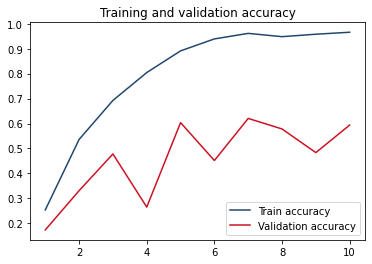

In [27]:
epochs = range(1, len(history2.history['accuracy'])+1)

plt.plot(epochs, history2.history['accuracy'], '#21466C', label='Train accuracy')
plt.plot(epochs, history2.history['val_accuracy'], '#cc1123', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# **CONCLUSION**

**ResNet was clearly the best performing model with a test accuracy of 61% on the 4000 test images from 100 classes using the epochs 10 where training dataset shows the accuracy of 97%**

# **RESNET:**
* Train Accuracy: 96.60%
* Validation Accuracy: 59.38%
* Test Accuracy: 61%

# **EfficientNet**
* Train Accuracy: 3.09%
* Validation Accuracy: 1.08%
* Test Accuracy: 1%